In [31]:
# Our standard network analysis module.
import networkx as nx
# Numpy can be more efficient at getting sum, max, min, etc. out of arrays and lists.
import numpy as np
# Can be used to make the printing of certain objects (especially dictionaries and tuples) easier for humans.
import pprint
# Just a lazy way of supressing warnings
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from IPython.core.display import HTML
from utils import plt_directed
import matplotlib.pyplot as plt
import mplleaflet

## 1) Ready to use graph with external data addition :

### 1.1) Ready to use version :

In [32]:
df_airport = pd.read_csv('./openflights/airports.dat.txt', header = None)
# Rename columns as it should be according to the documentation.
df_airport = df_airport.rename(columns ={0:'Airport_ID',
                                         1:'Name',
                                         2:'City',
                                         3:'Country',
                                         4:'IATA',
                                         5:'ICAO',
                                         6:'Latitude',
                                         7:'Longitude', 
                                         8:'Altitude',
                                         9:'Timezone', 
                                         10:'DST', 
                                         11:'Tz_database_time',
                                         12:'Type',
                                         13:'Source'})
df_airport.head()

,Airport_ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz_database_time,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [33]:
df_airport.shape

(7543, 14)

The goal of the 2 following cells is to check that the matching between the different ID is correct by looking at the first lines of our Airport_Network. Thus the loading of our edge list need to be done :

In [34]:
df_duplicates = pd.read_csv('./openflights/out.openflights', sep = ' ')
# Rename columns to give meaningful names
df_duplicates = df_duplicates.rename(columns = {'%':'Source_Node', 'asym':'Target_Node', 'positive':'Weight'})
df_duplicates.head()

,Source_Node,Target_Node,Weight
0,1,2,NaN
1,3,2,NaN
2,3,4,NaN
3,5,2,NaN
4,5,6,NaN


### 1.2) Addition of external data :

On *df_duplicates* dataframe, we can see that the first edge is between the node with ID 1 and with the node with ID 2. The second edge is between node 3 and 2. And the third is between node 3 and 4. These 3 edges should be the only one corresponding to the defined pair, implicating 1 and 3 as source nodes. The target node of the first and second edge should be the same airport. Thus, we will look at the data source of the edges list downloaded from again the same source ([Data Source](http://www.openflights.org/data.html)) and select the defined pairs of airports allowing us to see the correct behavior of the matching. These data are the one used to create Airport_Network from the link list as we explained above by selecting columns of interest and creating the edge list. 

In [35]:
df_routes = pd.read_csv('./openflights/routes.dat.txt', header = None)
print('DataFrame taking as the source node 1 and the target node 2 :')
display(HTML(df_routes[(df_routes[2]=='GKA')&(df_routes[4]=='MAG')].to_html())) # This command allows a nice printing of the dataframe in a HTML format.
print('DataFrame taking as the source node 3 and the target node 2 :')
display(HTML(df_routes[(df_routes[2]=='HGU')&(df_routes[4]=='MAG')].to_html()))
print('DataFrame taking as the source node 3 and the target node 4 :')
display(HTML(df_routes[(df_routes[2]=='HGU')&(df_routes[4]=='LAE')].to_html()))

DataFrame taking as the source node 1 and the target node 2 :


,0,1,2,3,4,5,6,7,8
17314,CG,1308,GKA,1,MAG,2,NaN,0,DH8


DataFrame taking as the source node 3 and the target node 2 :


,0,1,2,3,4,5,6,7,8
17322,CG,1308,HGU,3,MAG,2,NaN,0,DH8


DataFrame taking as the source node 3 and the target node 4 :


,0,1,2,3,4,5,6,7,8
17321,CG,1308,HGU,3,LAE,4,NaN,0,DH8


We select the node with ID 1 by looking at the *df_airport* dataframe to find the id name (ID node 1 = 'GKA'). In the column named IATA, we found the identifier ('GKA'). Then we use this identifier to select data in the routes dataframe. By selecting the corresponding source and target node using the IATA identifier, we find out that one route was existing per edge and that everything makes sense. Thus, the matching between the ID of the Airport_Network and the airport dataframe seems to be correct and can be used to add information on each node. We will add this new information directly on the node graph in the following cell.

In [36]:
def add_exogenous_feature(G, df_airport):
    '''
    This function allows the addition of external information on each node of the graph given as input.
    ARGS :
        - G : networkx graph object on which external information will be added.
        - df_airport : Pandas dataframe containing the new information to add.
    RETURN : 
        - G : networkx graph object containing new external information on each node.
    '''
    # Add exogenous information
    for i in G.node:
        if df_airport[df_airport.Airport_ID==i].shape[0] != 0:
            G.node[i]['City'] = df_airport[df_airport.Airport_ID==i]['City'].values[0]
            G.node[i]['Country'] = df_airport[df_airport.Airport_ID==i]['Country'].values[0]
            G.node[i]['Latitude'] = df_airport[df_airport.Airport_ID==i]['Latitude'].values[0]
            G.node[i]['Longitude'] = df_airport[df_airport.Airport_ID==i]['Longitude'].values[0]
        else :
            G.node[i]['City'] = np.nan
            G.node[i]['Country'] = np.nan
            G.node[i]['Latitude'] = np.nan
            G.node[i]['Longitude'] = np.nan
    return G

In [37]:
# Load the network from the raw edge list
Airport_Network = nx.read_edgelist('./openflights/out.openflights', create_using=nx.DiGraph(), comments='%', nodetype=int)
# Add external information
Airport_Network = add_exogenous_feature(Airport_Network, df_airport)

Airport_Network Informations Summary: 

Name: 
Type: DiGraph
Number of nodes: 3425
Number of edges: 37595
Average in degree:  10.9766
Average out degree:  10.9766 


Information of the node labeled 1 :
{ 'City': 'Goroka',
  'Country': 'Papua New Guinea',
  'Latitude': -6.0816898345900015,
  'Longitude': 145.391998291}


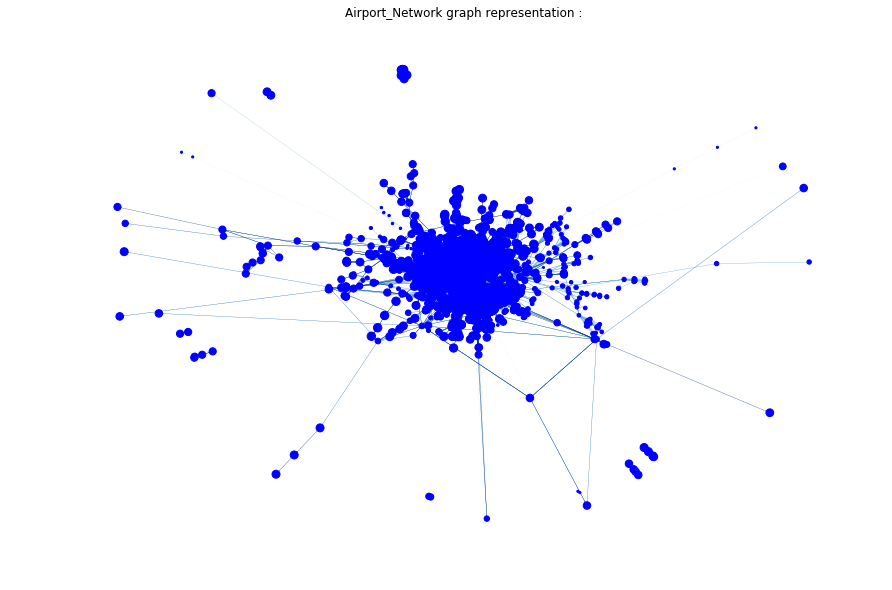

In [38]:
# print out the summary information of the graphs
print('Airport_Network Informations Summary: \n')
print(nx.info(Airport_Network),'\n')

pp = pprint.PrettyPrinter(indent=2)
# Example of the different attributes of an node
print('\nInformation of the node labeled 1 :')
pp.pprint(Airport_Network.node[1])

# Plot the graph thanks to the function define above
plt_directed(Airport_Network, 'Airport_Network graph representation :')

### 1.3) Geographical problem representation 

Even if we check the matching for some nodes (we before checked for 3 arbitrary nodes), we can see on the following geographical representation that the matching of airports corresponding to United States was not well achieved. This should be due to inconsistency between ID of the node in the ready to use version and the one of the raw dataframe. We will thus solve this issue in the following problem by directly taking the raw data from openflights webpage and not the 'ready to use version'.

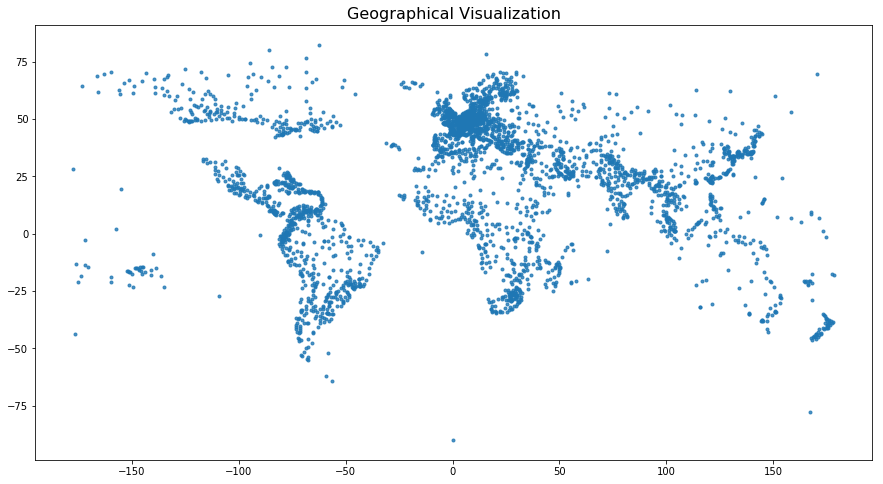

In [39]:
def pair_elements(*args):
    output = []
    for node_id in args[0].keys():
        output.append(tuple(i[node_id] for i in args))
    return np.array(output)

values = pair_elements(
    nx.get_node_attributes(Airport_Network, "Latitude"),
    nx.get_node_attributes(Airport_Network, "Longitude"),
)

plt.figure(figsize=(15, 8))
plt.scatter(values[:, 1], values[:, 0], alpha=0.8, marker='.')
plt.title("Geographical Visualization", fontsize=16)
plt.show()

## 2) Usage of raw data  :

**The goal of this section is to use the raw data from openflights webpage to add the entire set of nodes with a nice ID matching to have meaningful geographical representation.**

In fact, in the previous cell, we are able to see that some airports are missing, more specifically US airports are not in the data. As we want to analyze the world network, we investigate why this is the case. The conclusion is that the file *./openflights/out.openflights* is not complete when you compare the source Data found in the following links and there is a problem of match ID node for the US:
   * Link to the webpage where the dataset can be download : [OpenFlights Network Dataset](http://konect.uni-koblenz.de/networks/openflights)
   * Link corresponding to the real data source : [Data Source](http://www.openflights.org/data.html)

**Just below, we illustrate the problem about the number of nodes in the previously created graph. Moreover, we are able to conclude that the number of edges is corresponding to the raw data.**

In [40]:
# Here we first check the presence of duplicates in the airports data. As you can see, there are none duplicates.
print(df_airport.shape)
df_airport_tmp = df_airport.duplicated(keep = 'first')
print(df_airport_tmp.shape)

(7543, 14)
(7543,)


In [41]:
# Here we first check the presence of duplicates in the routes data. As you can see, there are none duplicates.
print(df_routes.shape)
df_routes_tmp = df_routes.duplicated(keep = 'first')
print(df_routes_tmp.shape)

(67663, 9)
(67663,)


In [42]:
print(f'Number of Airports in the raw data : {df_airport.shape[0]}')
print(f'Number of Airports in the graph coming from Konect website ready to use version  : {len(Airport_Network.nodes)}')
print(f'Number of Edges in the raw data : {df_routes.shape[0]}')
print(f'Number of Edges in the graph coming from Konect website ready to use version  : {len(Airport_Network.edges)}')

Number of Airports in the raw data : 7543
Number of Airports in the graph coming from Konect website ready to use version  : 3425
Number of Edges in the raw data : 67663
Number of Edges in the graph coming from Konect website ready to use version  : 37595


Here the number of edges is corresponding even if it's two times smaller : in fact, when we put data inside the graph, by construction, this number has to decrease by approximately a factor 2. In fact, the documentation says that in this network, 37.595 edges should be unique and that 67,663 edges in total should be existing.

We thus decided to use directly the raw data to construct our graph. To do that we follow the process below :

In [43]:
# Transform ID into string
df_airport['Airport_ID'] = df_airport['Airport_ID'].astype(str)
# Creation of the graph
Airport_Network=nx.DiGraph()
# First creation of the nodes
for i in df_airport.Airport_ID :
    Airport_Network.add_node(str(i))
# Creation of the edges in a second time
for i in df_routes.index :
    source_node = df_routes.loc[i][3]
    target_node = df_routes.loc[i][5]
    Airport_Network.add_edge(source_node, target_node) 
print(nx.info(Airport_Network),'\n')

Name: 
Type: DiGraph
Number of nodes: 7686
Number of edges: 37505
Average in degree:   4.8797
Average out degree:   4.8797 



In [44]:
# Add external information
Airport_Network = add_exogenous_feature(Airport_Network, df_airport)

Airport_Network Informations Summary: 

Name: 
Type: DiGraph
Number of nodes: 7686
Number of edges: 37505
Average in degree:   4.8797
Average out degree:   4.8797 


Information of the node labeled 1 :
{ 'City': 'Goroka',
  'Country': 'Papua New Guinea',
  'Latitude': -6.0816898345900015,
  'Longitude': 145.391998291}


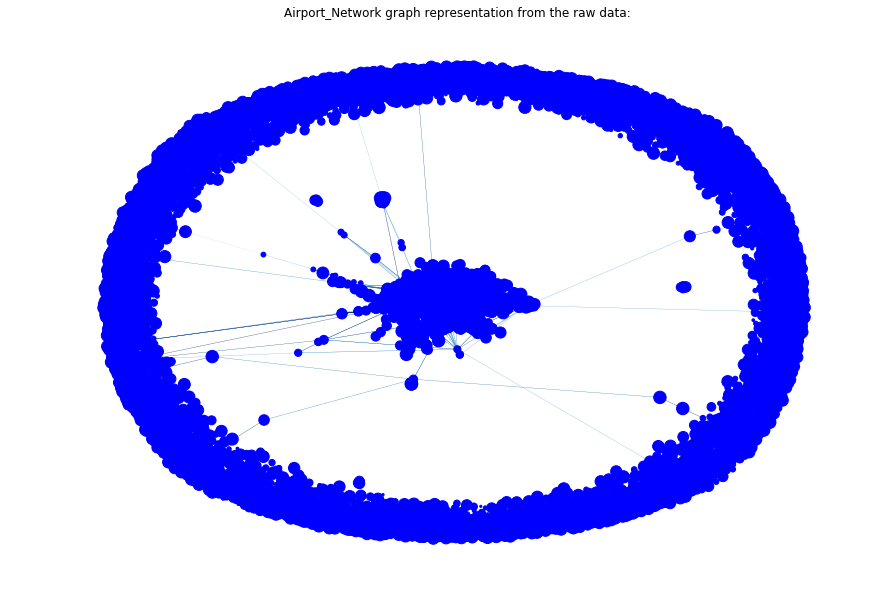

In [45]:
# print out the summary information of the graphs
print('Airport_Network Informations Summary: \n')
print(nx.info(Airport_Network),'\n')

pp = pprint.PrettyPrinter(indent=2)
# Example of the different attributes of an node
print('\nInformation of the node labeled 1 :')
pp.pprint(Airport_Network.node['1'])

# Plot the graph thanks to the function define above
plt_directed(Airport_Network, 'Airport_Network graph representation from the raw data:')

In [46]:
print(f'Number of Airports in the raw data : {df_airport.shape[0]}')
print(f'Number of Airports in the graph coming from raw data : {len(Airport_Network.nodes)}')
print(f'Number of Edges in the raw data : {df_routes.shape[0]}')
print(f'Number of Edges in the graph coming from raw data  : {len(Airport_Network.edges)}')

Number of Airports in the raw data : 7543
Number of Airports in the graph coming from raw data : 7686
Number of Edges in the raw data : 67663
Number of Edges in the graph coming from raw data  : 37505


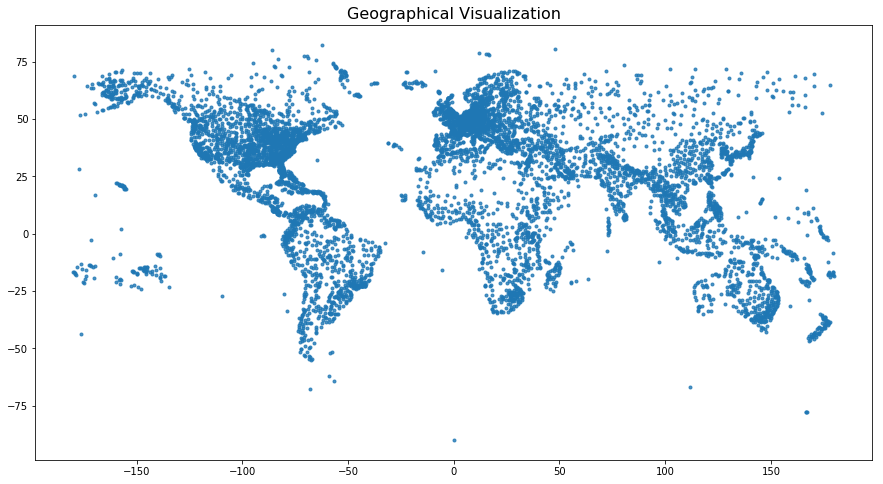

In [47]:
values = pair_elements(
    nx.get_node_attributes(Airport_Network, "Latitude"),
    nx.get_node_attributes(Airport_Network, "Longitude"),
)

plt.figure(figsize=(15, 8))
plt.scatter(values[:, 1], values[:, 0], alpha=0.8, marker='.')
plt.title("Geographical Visualization", fontsize=16)
plt.show()

***We can conclude that the usage of raw data solve the ID matching issue to allow a meaningful geographical representation***.

Thus, **a graph representing the routes of airports was created thanks to the raw data and not the 'ready to use' edge list**. Then, thanks to external data, **new information like Country or City** of the airport was added to each node. **At this stage, the graph is directed unweighted with external information on the node.**

***However, as you saw, in the first 'ready to use graph' the entire set of edges is already represented. This means that the majority of added nodes are not connected to the graph. This makes sense has the OpenFlights  Airports Database can also contain train stations and ferry terminals spanning the globe, nodes that we don't want to analyze. We will thus use another version of the graph for our study.*** 

***The explanation of the problem about the geographical representation with missing areas is that the matching with the raw data ID with the ready to use function is not correct. We will thus directly use the routes dataframe corresponding to the raw data to create a weighted directed graph use for the entire analysis. You can find this weighted graph creation in the notebook called Weighted_network.ipynb. This graph will be the one used for the entire report and represents well the world flight network. Not all the nodes will be present but the entire set of routes linking nodes will be included in our object of study.***